In [52]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim.lr_scheduler import StepLR
import time

In [53]:
# Constants
DATA_PATH = 'NewGeneratedData/'
MODELS_PATH = 'Models/'

BATCH_SIZE = 32
NUM_FEATURES = 285
EPOCHS = 20
LEARNING_RATE = 0.001

EARLY_STOP = False
EARLY_STOP_LEN = 5

RECORD = True   
FEATURE_SELECTOR = "None"

In [54]:
# Utility Functions
def load_data_frame(filename, sep='\s+', header=None):
    filepath = os.path.join(DATA_PATH, filename + '.txt')
    return pd.read_csv(filepath, header=header, sep=sep)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/lt/w0169b7x5ml3psz3nly9vj3m0000gn/T/ipykernel_60904/1393806629.py:2: SyntaxWarning: invalid escape sequence '\s'
  def load_data_frame(filename, sep='\s+', header=None):


In [55]:
FEATURES = load_data_frame("features")[0].to_list()

complete_set = load_data_frame("har_dataset")
complete_set.columns = FEATURES
train_set, test_set = train_test_split(complete_set, test_size=0.3, random_state=37)

train_set['activity'] = train_set['activity'].astype(int) - 1
test_set['activity'] = test_set['activity'].astype(int) - 1

activity_labels = load_data_frame('activity_labels')
activity_labels.columns = ['id', 'activity']
activity_labels['id'] = activity_labels['id'].astype(int) - 1

In [56]:
# Creating model
DEVICE = None

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# GRU Network class
class GRUNetwork(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=64, num_layers=2):
        super(GRUNetwork, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 256)  # Multiply by 2 for bidirectional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.batch_norm4 = nn.BatchNorm1d(32)

    def forward(self, x):
        x, _ = self.gru(x)  # x shape will be (batch_size, seq_len, hidden_size * 2)
        # x = x[:, -1, :]  # x shape will be (batch_size, hidden_size * 2)
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm4(self.fc4(x)))
        x = self.fc5(x)
        return x

In [57]:
model = GRUNetwork(input_size=NUM_FEATURES, num_classes=12).to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [58]:
# Training function for one model
def train_single_model(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

# Testing function for one model
def test_single_model(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    true_labels, pred_labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            # X = X.unsqueeze(1)
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            true_labels.extend(y.tolist())
            pred_labels.extend(pred.argmax(1).tolist())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return (f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"), confusion_matrix(true_labels, pred_labels)

In [59]:
# Dataset preparation
class HAPTDataset(Dataset):
    def __init__(self, dataset, features, label):
        self.data = torch.tensor(dataset[features].values, dtype=torch.float32)
        self.labels = torch.tensor(dataset[label].values, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

selected_columns = None
if FEATURE_SELECTOR != "None":  
    '''
    kbest_selector = SelectKBest(score_func=mutual_info_classif, k=NUM_FEATURES)
    selected_features = kbest_selector.fit_transform(complete_set[complete_set.columns[:-1]], complete_set['activity'])
    selected_columns = complete_set.columns[:-1][kbest_selector.get_support()]
    print(selected_columns)

    train_dataset = HAPTDataset(train_set, selected_columns, 'activity')
    test_dataset = HAPTDataset(test_set, selected_columns, 'activity')
    '''
else:
    train_dataset = HAPTDataset(train_set, train_set.columns[:-1], 'activity')
    test_dataset = HAPTDataset(test_set, train_set.columns[:-1], 'activity')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [60]:
perf_timer = time.perf_counter()
perf_acc, conf_matrix = None, None
perf_list = []

for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_single_model(train_dataloader, model, loss_function, optimizer)
    perf_acc, conf_matrix = test_single_model(test_dataloader, model, loss_function)
    perf_list.append(perf_acc)

print(perf_acc)
perf_timer = time.perf_counter() - perf_timer
percent_conf_matrix = 100 * conf_matrix.astype('float')/ conf_matrix.sum(axis=1)[:, np.newaxis]
print("Done!")

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Test Error: 
 Accuracy: 67.4%, Avg loss: 0.764670 

Done!


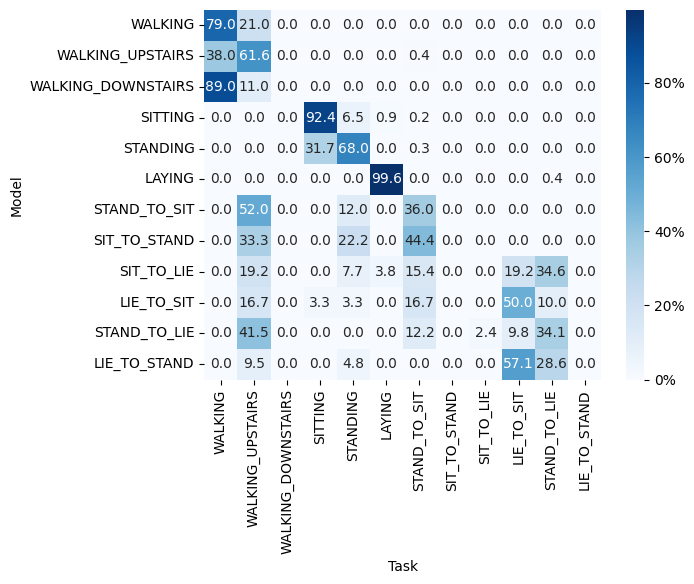

In [61]:
plot = sns.heatmap(percent_conf_matrix, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'format': '%.0f%%'}, xticklabels=activity_labels.activity, yticklabels=activity_labels.activity)
plot.set_xlabel("Task")
plot.set_ylabel("Model")

if RECORD:
    torch.save(model.state_dict(), MODELS_PATH + "Model_" + FEATURE_SELECTOR + ".pth")

    with open(MODELS_PATH + "Model_" + FEATURE_SELECTOR + ".txt", "w") as f:
        f.write("Epochs: {}\n".format(EPOCHS))
        f.write("Feature Selection: {}\n".format(FEATURE_SELECTOR))
        f.write("Feature Set: {}\n".format(selected_columns))
        f.write("Model: {}\n".format(str(model)))
        f.write("Loss Function: {}\n".format("Cross Entropy Loss"))
        f.write("Optimizer: {}\n\n\n\n".format(str(optimizer)))
        f.write("Results: {}\n".format(perf_acc))
        f.write("Timer: {}s\n".format(round(perf_timer, 2)))
        f.write("Confusion Matrix\n")
        f.write(str(conf_matrix))
        f.close()

    plot.get_figure().savefig(MODELS_PATH + "Model_" + FEATURE_SELECTOR + "_Matrix.png")